In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Sampler, BatchSampler, Dataset

import optuna

import tables
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import logging
import sys

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Load data

In [2]:
class ExpertDataset(Dataset):
    def __init__(self, images, actions):
        self._images = images
        self._actions = actions

    def __getitem__(self, index):
        return (self._images[index], self._actions[index])

    def __len__(self):
        return len(self._images)


class RandomBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size
        self.dataset_length = len(dataset)
        self.n_batches = self.dataset_length / self.batch_size
        self.batch_ids = torch.randperm(int(self.n_batches))

    def __len__(self):
        return self.batch_size

    def __iter__(self):
        for id in self.batch_ids:
            idx = torch.arange(id * self.batch_size, (id + 1) * self.batch_size)
            for index in idx:
                yield int(index)
        if int(self.n_batches) < self.n_batches:
            idx = torch.arange(int(self.n_batches) * self.batch_size, self.dataset_length)
            for index in idx:
                yield int(index)


def fast_loader(dataset, batch_size=32, drop_last=False, transforms=None):
    return DataLoader(
        dataset, batch_size=None,
        sampler=BatchSampler(RandomBatchSampler(dataset, batch_size), batch_size=batch_size, drop_last=drop_last)
    )

In [3]:
hdf5_file = tables.open_file('tmnf_1os.hdf5', mode="r")
images = np.moveaxis(hdf5_file.root.images[:], 3, 1)
actions = hdf5_file.root.actions[:]
hdf5_file.close()

size = images.shape[0]
fold = 0.3
rng = np.random.default_rng()
indexes = rng.choice(size, size=int(fold * size), replace=False)

images = images[indexes]
actions = actions[indexes]

images = torch.tensor(images / 255, dtype=torch.float32)
actions = torch.tensor(actions, dtype=torch.float32)

train_images, test_images, train_actions, test_actions = train_test_split(
    images, actions, test_size=0.15, random_state=42
)

In [4]:
train_dataset = ExpertDataset(train_images, train_actions)
test_dataset = ExpertDataset(test_images, test_actions)

# NN Model

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, conv_layers_types: list[str], conv_layers_outputs: list[int], kernel_sizes: list[int], strides: list[int]):
        super(NeuralNetwork, self).__init__()

        inputs = 4
        outputs = 4
        convw, convh = 53, 150
        layers = []

        for layer_type, layer_outputs, kernel_size, stride in zip(conv_layers_types, conv_layers_outputs, kernel_sizes, strides):
            layers.append(nn.Conv2d(inputs, layer_outputs, kernel_size=kernel_size, stride=stride, padding=0))
            if layer_type == 'relu':
                layers.append(nn.ReLU())
            elif layer_type == 'tanh':
                layers.append(nn.Tanh())
            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())
            inputs = layer_outputs
            convw = (convw - kernel_size) // stride + 1
            convh = (convh - kernel_size) // stride + 1

        layers.append(nn.Flatten())
        layers.append(nn.Linear(inputs * convw * convh, outputs))
        layers.append(nn.Sigmoid())

        self.layers_sequence = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.layers_sequence(x)
        return logits

# Training

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss = 0.
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0., 0.
    threshod = 0.5
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = pred > threshod
            correct += (pred == y).type(torch.float).sum().item() == len(y[0])
            # correct += (pred == y).type(torch.float).sum().item() / len(y[0])
    correct /= size
    # print(f"test accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}")
    return correct * 100, test_loss

# Optuna

In [22]:
def objective(trial):

    epochs = 20

    layer_1 = trial.suggest_categorical("layer_1", ["relu", "tanh", "sigmoid"])
    layer_2 = trial.suggest_categorical("layer_2", ["relu", "tanh", "sigmoid"])
    layer_3 = trial.suggest_categorical("layer_3", ["relu", "tanh", "sigmoid"])

    outs_1 = trial.suggest_categorical("outs_1", [16, 32, 64])
    outs_2 = trial.suggest_categorical("outs_2", [16, 32, 64, 128])
    outs_3 = trial.suggest_categorical("outs_3", [32, 64])
    
    kernel_size_1 = 8
    kernel_size_2 = 4
    kernel_size_3 = 3
    
    stride_1 = 4
    stride_2 = 2
    stride_3 = 1

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, log=True)

    layers = [layer_1, layer_2, layer_3]
    layers_out = [outs_1, outs_2, outs_3]
    kernel_sizes = [kernel_size_1, kernel_size_2, kernel_size_3]
    strides = [stride_1, stride_2, stride_3]

    model = NeuralNetwork(layers, layers_out, kernel_sizes, strides).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataloader = fast_loader(train_dataset, batch_size=batch_size)
    test_dataloader = fast_loader(test_dataset, batch_size=1)

    best = 0
    train_losses = []
    test_losses = []

    global global_best

    for epoch in range(epochs):
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        acc, test_loss = test(test_dataloader, model, loss_fn)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if acc > best:
            best = acc
            if best > global_best:
                global_best = best
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': test_loss,
                    'acc': acc,
                    'activations': layers,
                    'out_channels': layers_out,
                    'kernel_sizes': kernel_sizes
                    }, f'{trial.number}-{epoch}-acc{int(acc)}'
                )

    _fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    epochs_t = [epoch for epoch in range(epochs)]
    _ = axs[0].plot(epochs_t, train_losses, 'b')
    _ = axs[1].plot(epochs_t, test_losses, 'r')
    
    return best
    

# Test

[I 2022-06-28 23:16:28,626] A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed


A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed
A new study created in memory with name: no-name-562a0a9c-e89d-43ba-83fe-7be487b52aed


[I 2022-06-28 23:17:13,722] Trial 0 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'tanh', 'outs_1': 64, 'outs_2': 64, 'outs_3': 64, 'learning_rate': 2.111839097467436e-05, 'batch_size': 479}. Best is trial 0 with value: 36.98290810007431.


Trial 0 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'tanh', 'outs_1': 64, 'outs_2': 64, 'outs_3': 64, 'learning_rate': 2.111839097467436e-05, 'batch_size': 479}. Best is trial 0 with value: 36.98290810007431.
Trial 0 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'tanh', 'outs_1': 64, 'outs_2': 64, 'outs_3': 64, 'learning_rate': 2.111839097467436e-05, 'batch_size': 479}. Best is trial 0 with value: 36.98290810007431.
Trial 0 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'tanh', 'outs_1': 64, 'outs_2': 64, 'outs_3': 64, 'learning_rate': 2.111839097467436e-05, 'batch_size': 479}. Best is trial 0 with value: 36.98290810007431.
Trial 0 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'tanh', 'outs_1': 64, 'outs_2': 64, 'outs_3': 64, 'learning_rate'

[I 2022-06-28 23:17:54,562] Trial 1 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.00012060229595919095, 'batch_size': 88}. Best is trial 0 with value: 36.98290810007431.


Trial 1 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.00012060229595919095, 'batch_size': 88}. Best is trial 0 with value: 36.98290810007431.
Trial 1 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.00012060229595919095, 'batch_size': 88}. Best is trial 0 with value: 36.98290810007431.
Trial 1 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.00012060229595919095, 'batch_size': 88}. Best is trial 0 with value: 36.98290810007431.
Trial 1 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate'

[I 2022-06-28 23:18:34,874] Trial 2 finished with value: 40.94624721327719 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'sigmoid', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.0005933879304671034, 'batch_size': 35}. Best is trial 2 with value: 40.94624721327719.


Trial 2 finished with value: 40.94624721327719 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'sigmoid', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.0005933879304671034, 'batch_size': 35}. Best is trial 2 with value: 40.94624721327719.
Trial 2 finished with value: 40.94624721327719 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'sigmoid', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.0005933879304671034, 'batch_size': 35}. Best is trial 2 with value: 40.94624721327719.
Trial 2 finished with value: 40.94624721327719 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'sigmoid', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learning_rate': 0.0005933879304671034, 'batch_size': 35}. Best is trial 2 with value: 40.94624721327719.
Trial 2 finished with value: 40.94624721327719 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'sigmoid', 'layer_3': 'relu', 'outs_1': 64, 'outs_2': 32, 'outs_3': 32, 'learn

[I 2022-06-28 23:19:01,459] Trial 3 finished with value: 0.0 and parameters: {'layer_1': 'tanh', 'layer_2': 'relu', 'layer_3': 'relu', 'outs_1': 16, 'outs_2': 128, 'outs_3': 64, 'learning_rate': 0.0033468260286227875, 'batch_size': 185}. Best is trial 2 with value: 40.94624721327719.


Trial 3 finished with value: 0.0 and parameters: {'layer_1': 'tanh', 'layer_2': 'relu', 'layer_3': 'relu', 'outs_1': 16, 'outs_2': 128, 'outs_3': 64, 'learning_rate': 0.0033468260286227875, 'batch_size': 185}. Best is trial 2 with value: 40.94624721327719.
Trial 3 finished with value: 0.0 and parameters: {'layer_1': 'tanh', 'layer_2': 'relu', 'layer_3': 'relu', 'outs_1': 16, 'outs_2': 128, 'outs_3': 64, 'learning_rate': 0.0033468260286227875, 'batch_size': 185}. Best is trial 2 with value: 40.94624721327719.
Trial 3 finished with value: 0.0 and parameters: {'layer_1': 'tanh', 'layer_2': 'relu', 'layer_3': 'relu', 'outs_1': 16, 'outs_2': 128, 'outs_3': 64, 'learning_rate': 0.0033468260286227875, 'batch_size': 185}. Best is trial 2 with value: 40.94624721327719.
Trial 3 finished with value: 0.0 and parameters: {'layer_1': 'tanh', 'layer_2': 'relu', 'layer_3': 'relu', 'outs_1': 16, 'outs_2': 128, 'outs_3': 64, 'learning_rate': 0.0033468260286227875, 'batch_size': 185}. Best is trial 2 wit

[I 2022-06-28 23:19:30,042] Trial 4 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'sigmoid', 'outs_1': 16, 'outs_2': 128, 'outs_3': 32, 'learning_rate': 1.7431707459496533e-05, 'batch_size': 34}. Best is trial 2 with value: 40.94624721327719.


Trial 4 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'sigmoid', 'outs_1': 16, 'outs_2': 128, 'outs_3': 32, 'learning_rate': 1.7431707459496533e-05, 'batch_size': 34}. Best is trial 2 with value: 40.94624721327719.
Trial 4 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'sigmoid', 'outs_1': 16, 'outs_2': 128, 'outs_3': 32, 'learning_rate': 1.7431707459496533e-05, 'batch_size': 34}. Best is trial 2 with value: 40.94624721327719.
Trial 4 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'sigmoid', 'outs_1': 16, 'outs_2': 128, 'outs_3': 32, 'learning_rate': 1.7431707459496533e-05, 'batch_size': 34}. Best is trial 2 with value: 40.94624721327719.
Trial 4 finished with value: 36.98290810007431 and parameters: {'layer_1': 'sigmoid', 'layer_2': 'tanh', 'layer_3': 'sigmoid', 'outs_1': 16, 'outs_2': 128, 'outs_3': 32,

KeyboardInterrupt: 

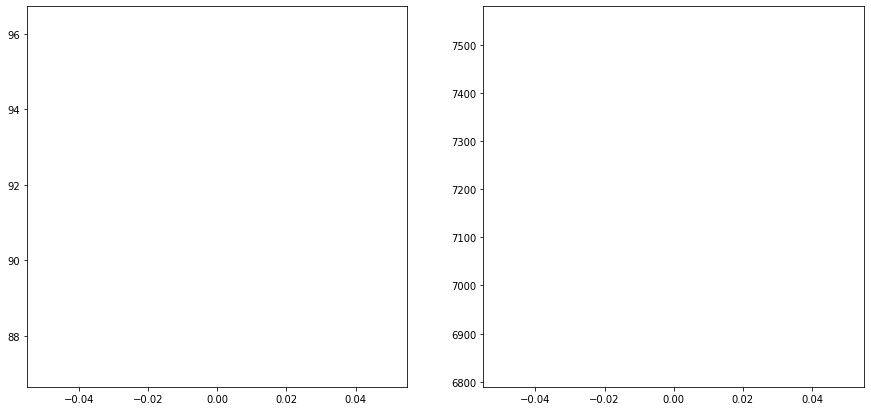

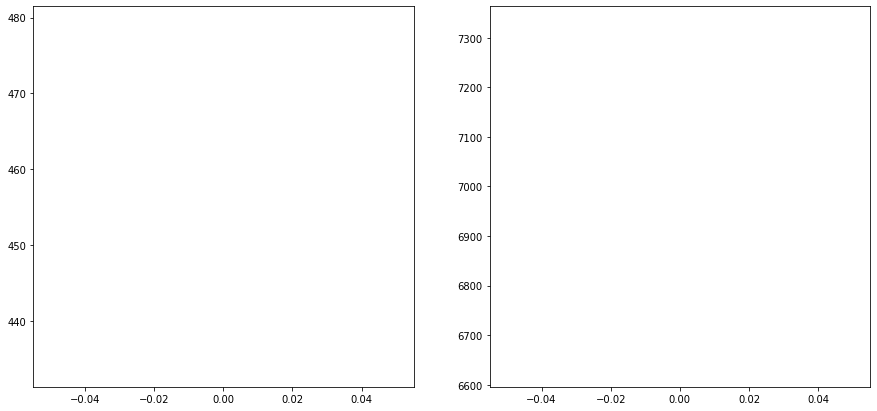

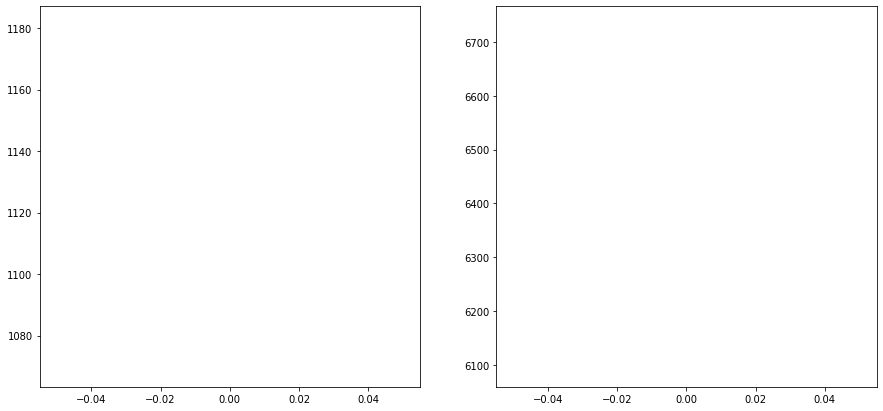

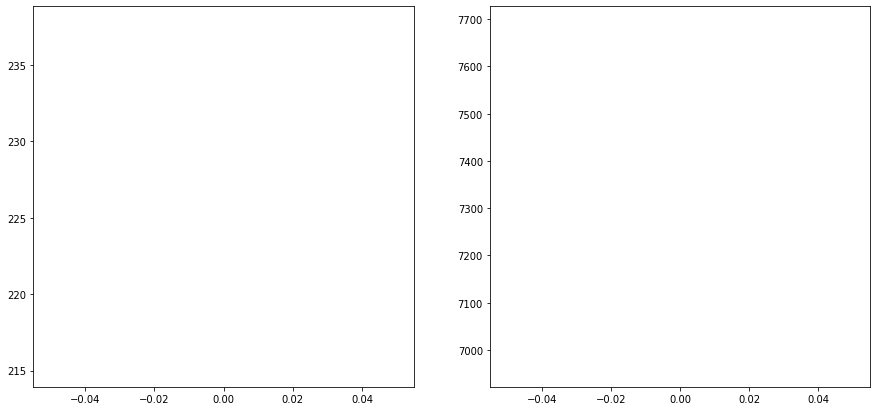

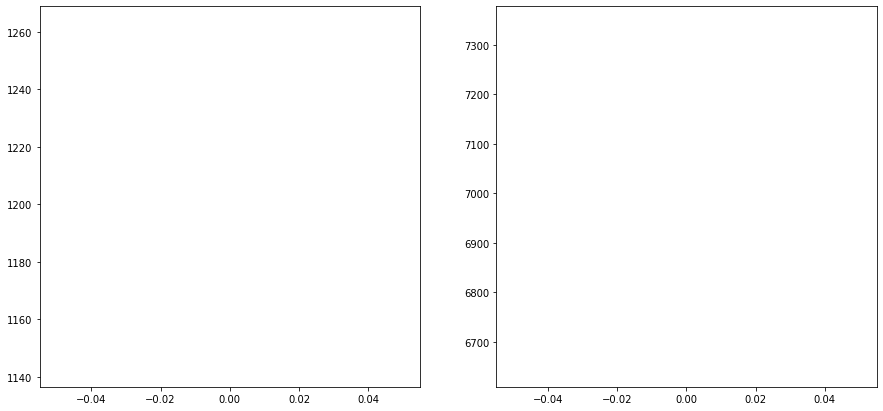

In [23]:
global_best = 0

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

trial = study.best_trial

print("Best trial:")
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))